In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
import networkx as nx
import torch

In [2]:
from omegaconf import DictConfig
from topobench.data.loaders.graph.hypbench_dataset import HypBenchDatasetLoader

# Example parameters
params = DictConfig({
    "N_n": 2000,        # Number of nodes
    "beta": 2,        # Clustering coefficient control
    "gamma": 2.5,       # Power-law exponent for node degrees
    "kmean": 10.0,      # Mean degree in unipartite network
    "N_f": 500,         # Number of node features
    "beta_b": 1.5,      # Bipartite clustering control (topology-features correlation)
    "gamma_n": 2.5,     # Power-law exponent for node degrees in bipartite network
    "gamma_f": 2.5,     # Power-law exponent for feature degrees in bipartite network
    "kmean_n": 10.0,    # Mean node degree in bipartite network
    "N_c": 6,           # Number of classes
    "alpha": 8.0,       # Homophily strength
    "data_dir": "/tmp"  # Required by AbstractLoader, can be any path
})

loader = HypBenchDatasetLoader(params)
dataset = loader.load_dataset()

In [3]:
print(dataset.data.x.shape)  # Node features
print(dataset.data.y.shape)  # Labels

torch.Size([2000, 500])
torch.Size([2000])


/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_95214/3050551390.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print(dataset.data.x.shape)  # Node features
/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_95214/3050551390.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print(dataset.data.y.shape)  # Labels


In [4]:
data = dataset.data

/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_95214/2168711401.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  data = dataset.data


In [5]:
data

Data(x=[2000, 500], edge_index=[2, 19160], y=[2000], thetas=[2000], kappas=[2000], radii=[2000], thetas_f=[500], kappas_f=[500], kappas_n=[2000], radii_n=[2000], radii_f=[500], num_nodes=2000, num_node_features=500, num_classes=6)

In [6]:
from torch_geometric.utils import to_networkx
g = to_networkx(data, to_undirected=True, node_attrs=['thetas', 'kappas', 'radii', 'y'])
print(g)

Graph with 2000 nodes and 9580 edges


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9580/9580 [00:00<00:00, 10923.30it/s]


Text(0.5, 1.0, 'Unipartite network')

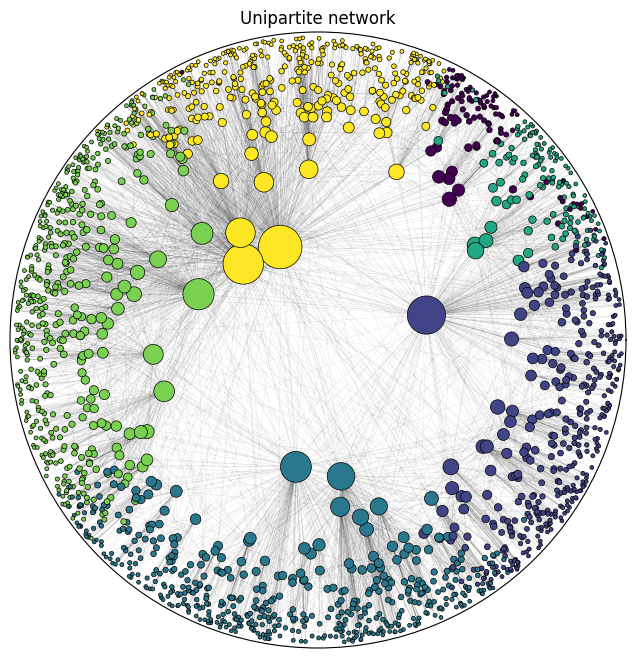

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

for source, target in tqdm(g.edges()):
    s = g.nodes[source]
    t = g.nodes[target] 
    ax.plot([s['thetas'], t['thetas']], [s['radii'], t['radii']], 
            color='black', alpha=0.3, linewidth=0.1)

thetas = nx.get_node_attributes(g, 'thetas').values()
radii = list(nx.get_node_attributes(g, 'radii').values())
kappas = list(nx.get_node_attributes(g, 'kappas').values())
labels = list(nx.get_node_attributes(g, 'y').values())

ax.scatter(thetas, radii, c=labels, edgecolors='black',
           s=2*np.array(kappas), alpha=1, linewidths=0.5, zorder=30)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, np.max(radii) + 0.2)
ax.set_title('Unipartite network')

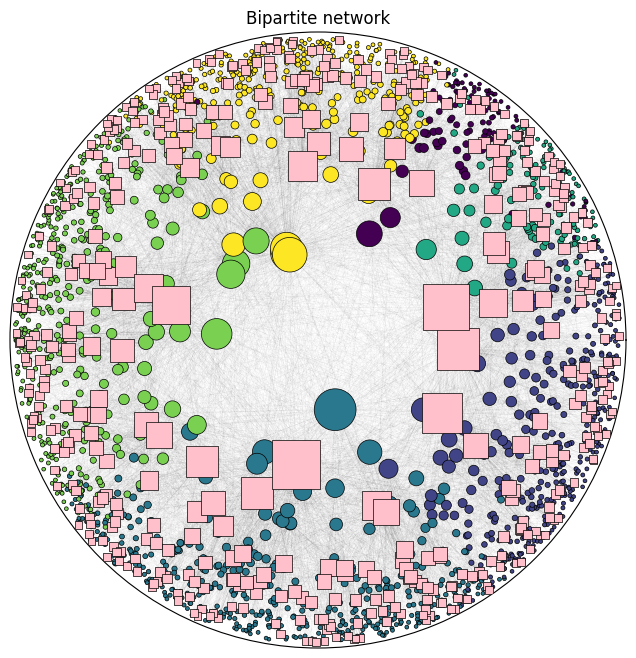

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

thetas_n = data.thetas
radii_n = data.radii_n
kappas_n = np.array(data.kappas_n)
labels = data.y

thetas_f = data.thetas_f
radii_f = data.radii_f
kappas_f = np.array(data.kappas_f)

for s, t in torch.nonzero(data.x):
    ax.plot([thetas_n[s], thetas_f[t]], [radii_n[s], radii_f[t]], 
            color='black', alpha=0.2, linewidth=0.05)

ax.scatter(thetas_n, radii_n, c=labels, edgecolors='black',
           s=2*kappas_n, alpha=1, linewidths=0.5, zorder=30)
ax.scatter(thetas_f, radii_f, marker='s', edgecolors='black',
           alpha=1, s=2*kappas_f, color='pink',linewidths=0.5, zorder=30)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, np.max(radii_n) + 0.2)
ax.set_title('Bipartite network')
plt.show()